In [10]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
import matplotlib.pyplot as plt
import seaborn as sns

# Load datasets
customers_df = pd.read_csv('Customers.csv')
transactions_df = pd.read_csv('Transactions.csv')



In [11]:
# Step 1: Preprocess transaction data to aggregate it by CustomerID
customer_transactions = transactions_df.groupby('CustomerID').agg({
    'Quantity': 'sum',
    'TotalValue': 'sum',
    'TransactionID': 'count'  # Number of transactions
}).rename(columns={'TransactionID': 'TransactionCount'}).reset_index()

# Merge aggregated data with customer profile data
customer_profile = customers_df.merge(customer_transactions, on='CustomerID', how='inner')

# Encode categorical variable (Region)
customer_profile = pd.get_dummies(customer_profile, columns=['Region'], drop_first=True)

# Drop non-numeric columns not needed for clustering
clustering_data = customer_profile.drop(columns=['CustomerID', 'CustomerName', 'SignupDate'])

# Standardize the data for clustering
scaler = StandardScaler()
scaled_data = scaler.fit_transform(clustering_data)



In [12]:
# Step 2: Apply clustering and calculate metrics
clusters_range = range(2, 11)
db_scores = []
kmeans_models = []

for n_clusters in clusters_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(scaled_data)
    db_index = davies_bouldin_score(scaled_data, kmeans.labels_)
    db_scores.append(db_index)
    kmeans_models.append(kmeans)

# Identify the optimal number of clusters with the lowest DB Index
optimal_clusters = clusters_range[db_scores.index(min(db_scores))]

# Use the best KMeans model
best_kmeans = kmeans_models[db_scores.index(min(db_scores))]
customer_profile['Cluster'] = best_kmeans.labels_



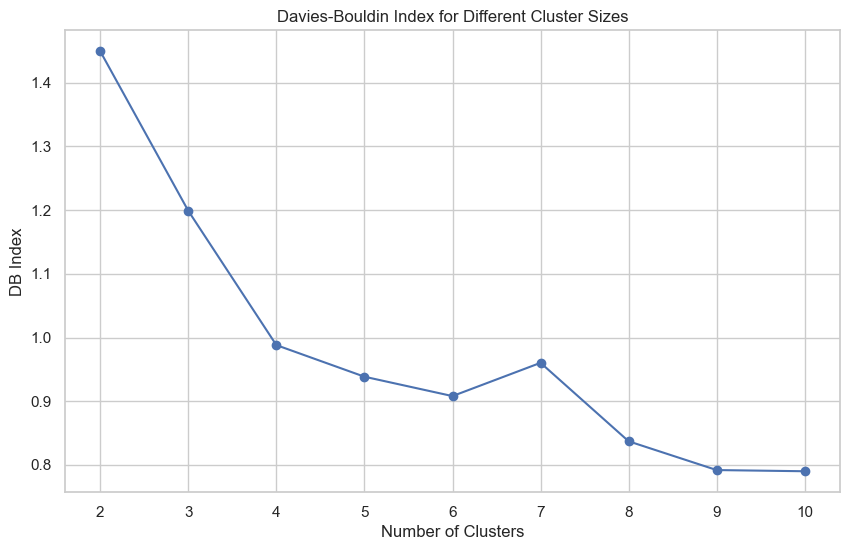

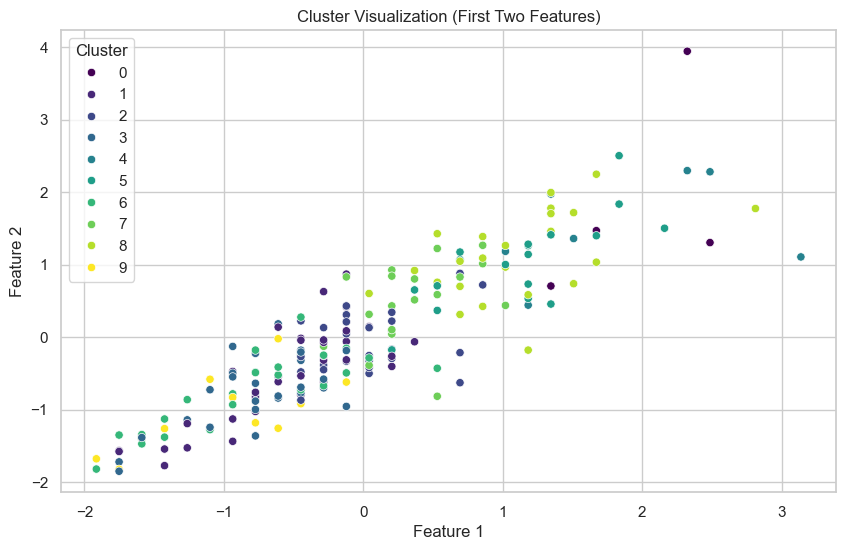

In [13]:
# Step 3: Visualize clusters
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
plt.plot(clusters_range, db_scores, marker='o')
plt.title('Davies-Bouldin Index for Different Cluster Sizes')
plt.xlabel('Number of Clusters')
plt.ylabel('DB Index')
plt.xticks(clusters_range)
plt.show()

# Plot 2D visualization using first two features
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=scaled_data[:, 0], y=scaled_data[:, 1], hue=customer_profile['Cluster'],
    palette='viridis', legend='full', edgecolor='w'
)
plt.title('Cluster Visualization (First Two Features)')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend(title='Cluster')
plt.show()



In [14]:
# Save the clustering results
top_summary = {
    "Optimal Clusters": optimal_clusters,
    "Min DB Index": min(db_scores),
    "Cluster Distribution": customer_profile['Cluster'].value_counts().to_dict()
}

print("Clustering Summary:")
print(top_summary)

# Save results to CSV
customer_profile.to_csv('Customer_Segmentation_Results.csv', index=False)


Clustering Summary:
{'Optimal Clusters': 10, 'Min DB Index': np.float64(0.79002838575684), 'Cluster Distribution': {1: 35, 3: 27, 6: 26, 2: 26, 8: 24, 7: 19, 5: 18, 9: 13, 4: 7, 0: 4}}
